[StackOverflow](https://stackoverflow.com/questions/28935983/preprocessing-image-for-tesseract-ocr-with-opencv)

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider

In [2]:
image_path = "D:/riconoscimento_numeri/imgs/test_audi.png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)

print(image.ndim)
print(type(image))

2
<class 'numpy.ndarray'>


In [3]:
import numpy as np
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
blue = make_colormap([c("black"), c("blue")])
green = make_colormap([c("black"), c("green")])
red = make_colormap([c("black"), c("red")])

def show_splitted(img):
    splitted = cv2.split(img)
    print(len(splitted))
    plt.imshow(splitted[0], cmap=blue)
    plt.show()
    plt.imshow(splitted[1], cmap=green)
    plt.show()
    plt.imshow(splitted[2], cmap=red)
    plt.show()

3


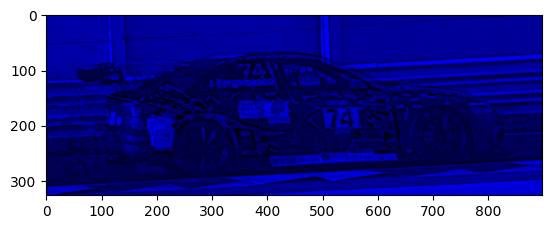

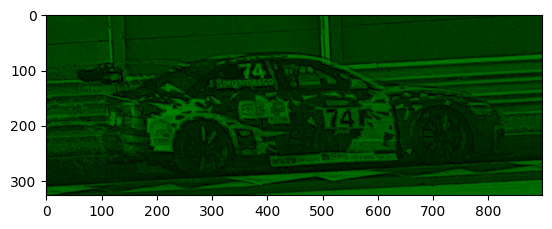

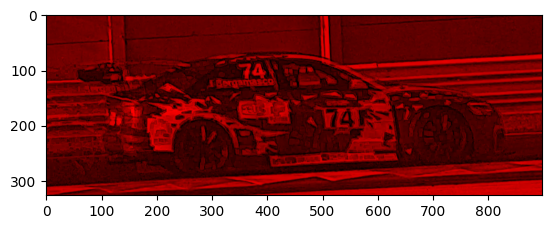

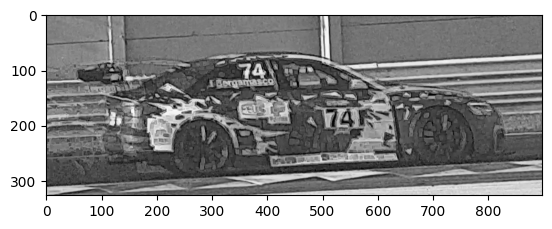

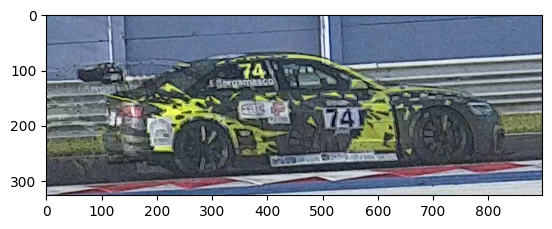

In [4]:

show_splitted(image_color)

plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
esempio = image_color[0][0]

mediana = np.median(esempio)

varianza = np.std(esempio)

print(esempio)
print(varianza)
print(np.var(esempio))
print(mediana)

[155 121 101]
22.291004663067316
496.88888888888886
121.0


In [6]:
import numpy as np

def inverse_thres( inverse_thres = 128, variance = 0):

    new_image = np.zeros((len(image_color), len(image_color[0])), dtype=np.uint8)
    
    for i in range(len(image_color)):
        for j in range(len(image_color[i])):


            mean = np.uint8(np.mean(image_color[i][j]))

            var = np.std(image_color[i][j])

            if mean > inverse_thres and var < variance:
                new_image[i][j] = mean
            else:
                new_image[i][j] = 0
    
    plt.imshow(new_image, cmap="gray")
    plt.show()

    return new_image

interact(inverse_thres, inverse_thres = IntSlider(min=0, max=255, step=1, value=128), variance = IntSlider(min=0, max=255, step=1, value=0))




interactive(children=(IntSlider(value=128, description='inverse_thres', max=255), IntSlider(value=0, descripti…

<function __main__.inverse_thres(inverse_thres=128, variance=0)>

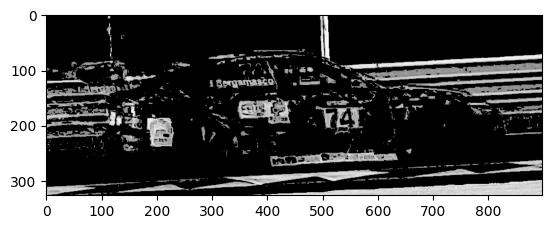

In [14]:
thres = inverse_thres(125, 18)


In [17]:
def calc_epsilon(e = 0.0661):
    print(e)
    contours, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    converted = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(converted, contours, -1, (255, 0, 0), 3)

    for contour in contours:
        epsilon = e * cv2.arcLength(contour, False)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if w > 20 and h > 20 and len(approx) == 4:
            print("approx ", approx, "bounds ", (x, y),(x+w, y+h))
            cv2.drawContours(converted, [approx], -1, (0, 255, 0), 3)
            #converted = cv2.rectangle(converted,  (x, y),(x+w, y+h), (0, 0, 255))
            cut = image[y:y+h, x:x+w]
            plt.imshow(cut, cmap="gray")
            plt.show()
                

    plt.imshow(converted)
    plt.show()

interact(calc_epsilon, e=FloatSlider(min=0.0001, max=0.1, value=0.0661, step=0.001))

interactive(children=(FloatSlider(value=0.0661, description='e', max=0.1, min=0.0001, step=0.001), Output()), …

<function __main__.calc_epsilon(e=0.0661)>

In [9]:


thres = None

def f(blockSize, c):

    thres = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, c)

    plt.imshow(thres, cmap='gray')
    plt.show()

interact(f, blockSize=IntSlider(min=3, max=500, step=2, value=3), c=IntSlider(min=-200, max=255, step=1, value=0))

interactive(children=(IntSlider(value=3, description='blockSize', max=500, min=3, step=2), IntSlider(value=0, …

<function __main__.f(blockSize, c)>

In [10]:
def f2(div, c):

    simplified = image // div * div + div //2
    _, new_thres = cv2.threshold(simplified,c,  255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    new_contours = []

    for contour in contours:
        epsilon = 0.06 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if w / h > 0.5 and w / h < 2 and len(contour) > 10 and w > 10 and h > 10:
            #color = cv2.rectangle(color, (x, y), (x+w, y+h), (255, 0, 0), 2)
            new_contours.append(approx)

    plt.imshow(simplified, cmap='gray')
    plt.show()
    plt.imshow(new_thres, cmap='gray')
    plt.show()

    color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(color, contours, -1, (0, 0, 255), 2)
    cv2.drawContours(color, new_contours, -1, (0, 255, 0), 2)
    plt.imshow(color)
    plt.show()


interact(f2, div=IntSlider(min=2, max=256, step=2, value=16), c=IntSlider(min=-200, max=255, step=1, value=0))

interactive(children=(IntSlider(value=16, description='div', max=256, min=2, step=2), IntSlider(value=0, descr…

<function __main__.f2(div, c)>

In [11]:
col_contours, _ = cv2.findContours(image_color, cv2.FLOODFILL_FIXED_RANGE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(cv2.drawContours(image_color, col_contours, -1, (0, 255, 0), 3))

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours_new.cpp:330: error: (-2:Unspecified error) in function 'class std::shared_ptr<struct ContourScanner_> __cdecl ContourScanner_::create(class cv::Mat,int,int,class cv::Point_<int>)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 16 (CV_8UC3)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


In [ ]:

color = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)

contours, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

new_contours = []

for contour in contours:
    epsilon = 0.06 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    x, y, w, h = cv2.boundingRect(approx)
    if w / h > 0.5 and w / h < 2 and len(contour) > 10 and w > 10 and h > 10:
        #color = cv2.rectangle(color, (x, y), (x+w, y+h), (255, 0, 0), 2)
        new_contours.append(approx)

#cv2.drawContours(color, new_contours, -1, (0, 255, 0), 2)
plt.imshow(color)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


C:\Users\michi\AppData\Local\Temp\ipykernel_5332\2901171571.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


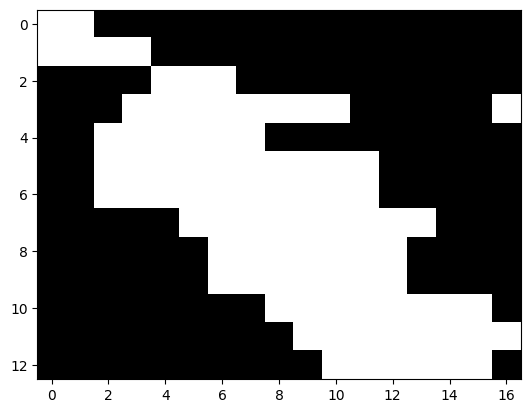

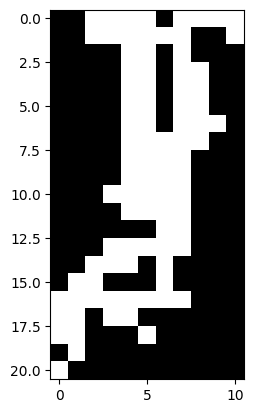

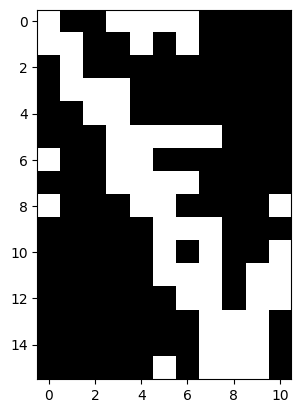

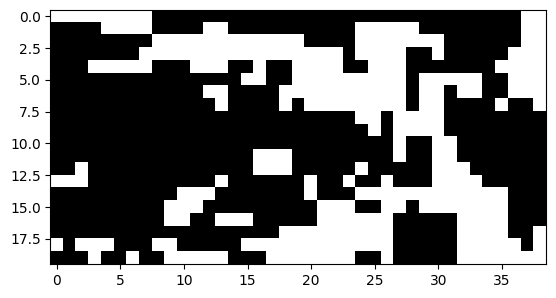

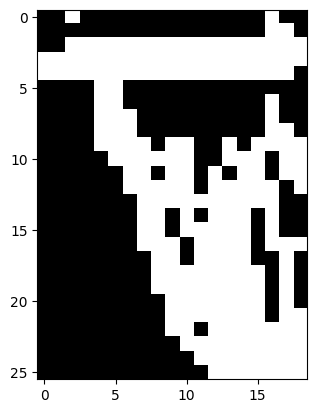

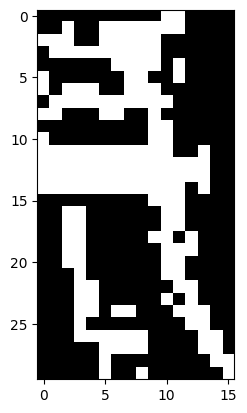

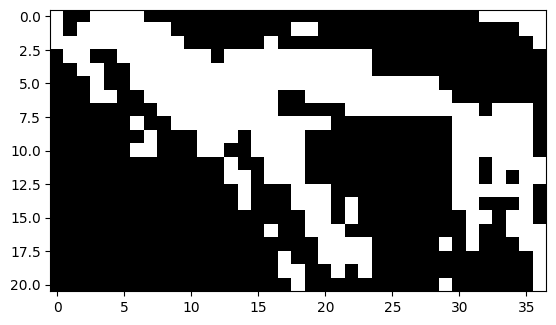

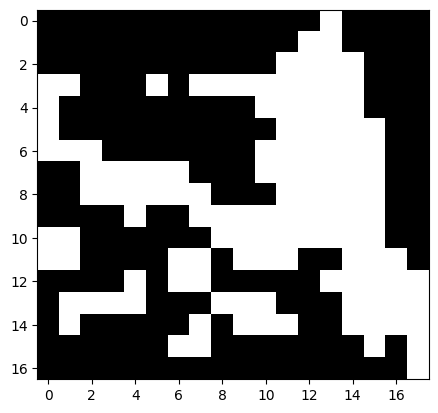

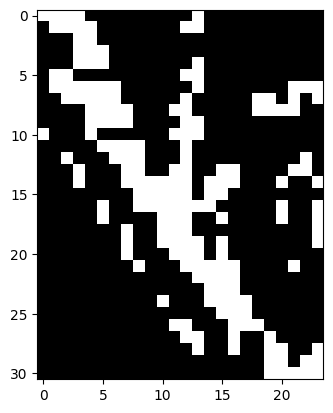

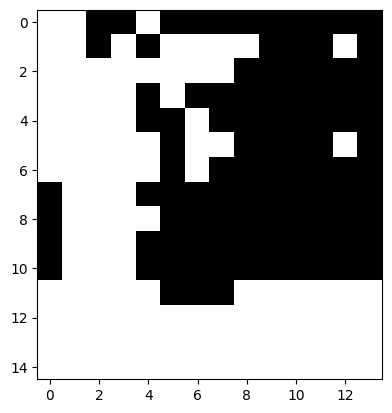

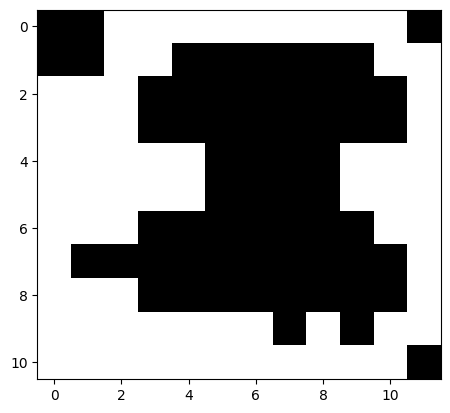

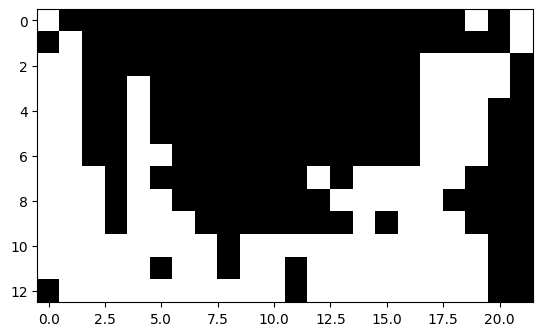

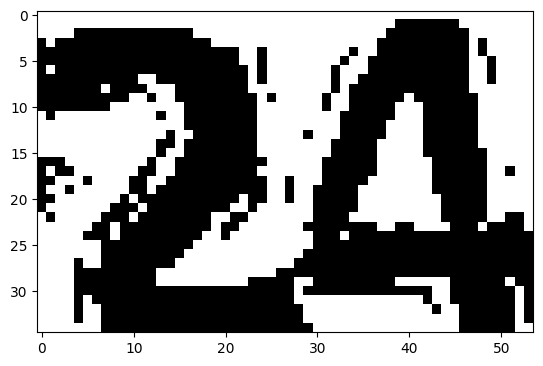

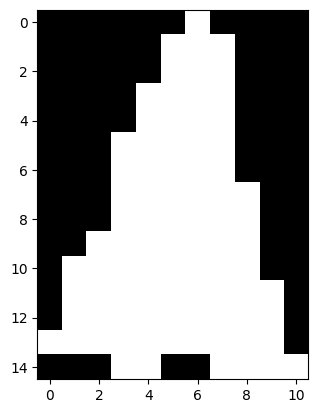

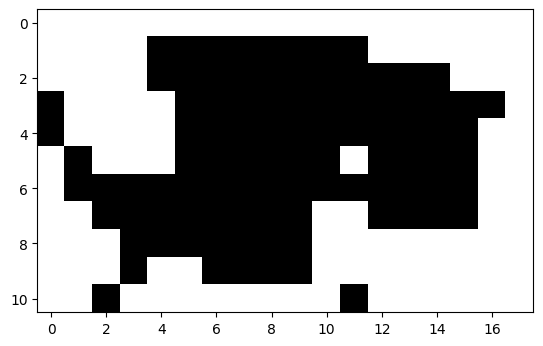

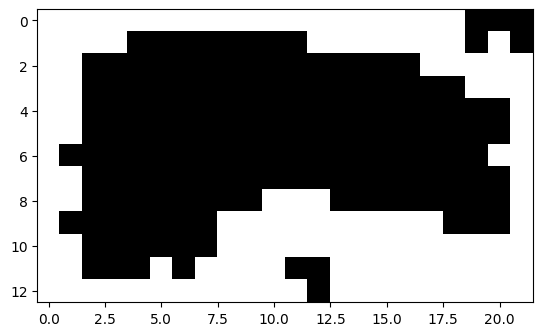

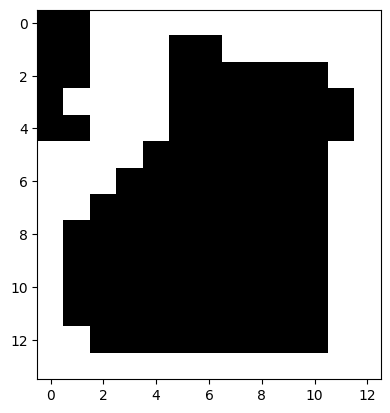

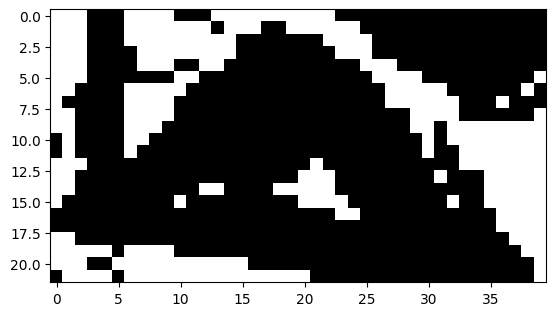

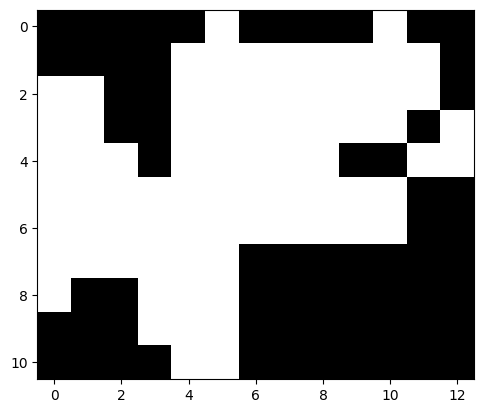

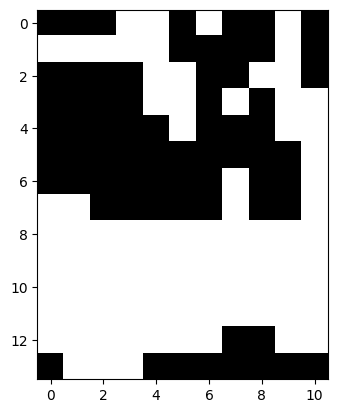

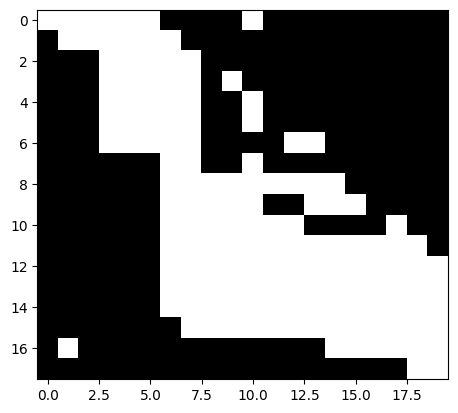

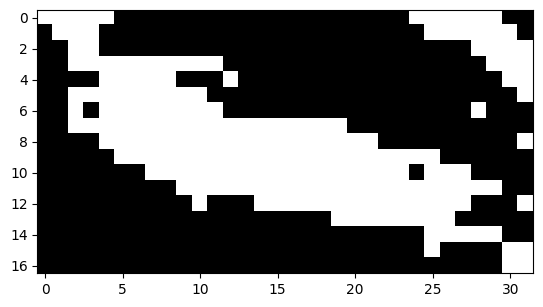

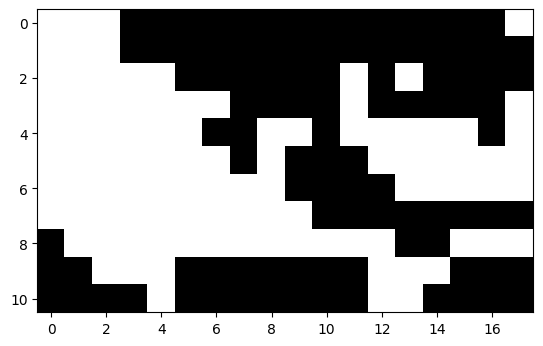

In [ ]:
for i, contour in enumerate(new_contours):
    x, y, w, h = cv2.boundingRect(contour)
    plt.figure()
    plt.imshow(color[y:y+h, x:x+w])